In [3]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
source("../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

SVM is used as an intermediary because it comes from python and then it is integrated to each feature usage datasets.

In [8]:
#SVM <- read.table("final_prognosis/SVM_comp.csv",sep=',',header=T)
#SVM <- cbind(SVM,read.table("final_prognosis/SVM_add_eln_comp.csv",sep=',',header=T)[1:10,])
list_models <- list.files('Prognosis_results')[list.files('Prognosis_results')!="SVM_comp.csv" & list.files('Prognosis_results')!="SVM_add_eln_comp.csv" & list.files('Prognosis_results')!="age.tsv"
                                            & list.files('Prognosis_results')!="neural_network_all_features.tsv" & list.files('Prognosis_results')!="launch.R" &
                                               list.files('Prognosis_results')!="launch1.R" & list.files('Prognosis_results')!="launch2.R"]
df_w_all <-NULL
for (l in list_models){
  #tmp <- cbind(read.table(paste("final_prognosis",l,sep="/"))[1:10,],SVM_optimized=SVM[,substr(l,1,nchar(l)-4)])    
  tmp <- read.table(paste("Prognosis_results",l,sep="/"))
  tmp$model <- substr(l,1,nchar(l)-4)
  
  assign(substr(l,1,nchar(l)-4),melt(tmp,id='model')) 
  df_w_all <- rbind(df_w_all,get(substr(l,1,nchar(l)-4)))
}
## add dl
#w <- data.frame(model=rep('all_features',10),variable=rep("deep neural network",10),value=val_dl)
#df_w_all <- rbind(read.table("final_prognosis/neural_network_all_features.tsv"),df_w_all)
colnames(df_w_all) <- c('model','algorithm','CI_test')
model_medians<-c()
df_w_all$model<-factor(df_w_all$model,levels=substr(list_models,1,nchar(list_models)-4))
for( model in levels(df_w_all$model)){

   model_medians <- c(model_medians,median(df_w_all$CI_test[df_w_all$model==as.character(model)],na.rm=T))
}
model_medians<-data.frame(model=levels(df_w_all$model),Z=model_medians)

In [3]:
###### Preparation worst and best

In [9]:
tmp_top <- model_medians[order(model_medians$Z,decreasing=T),]
top <- tmp_top[tmp_top$Z>0.699,]
tmp_worst <- model_medians[order(model_medians$Z,decreasing=T),]
worst <- tmp_worst[tmp_worst$Z<0.622,]
df_w_top <- df_w_all[is.element(df_w_all$model,unique(top$model)),]
df_w_worst <- df_w_all[is.element(df_w_all$model,unique(worst$model)),]

##### Conclusion: Clinical and demographical are the more important features for the prognosis models.
##### The eln is also an important parameter because it is solo and it definitely imporves prognosis

##### Of course adding genetical and cytogenetical data slightly improve the overallsurvival prognosis.
##### Adding genetical information or cytogenetical information of component information has the same effect on prognosis when we have clinical and demographical features used for evaluation.

In [10]:
dim(df_w_all)

[1] 16425     3

# ALL MODELS

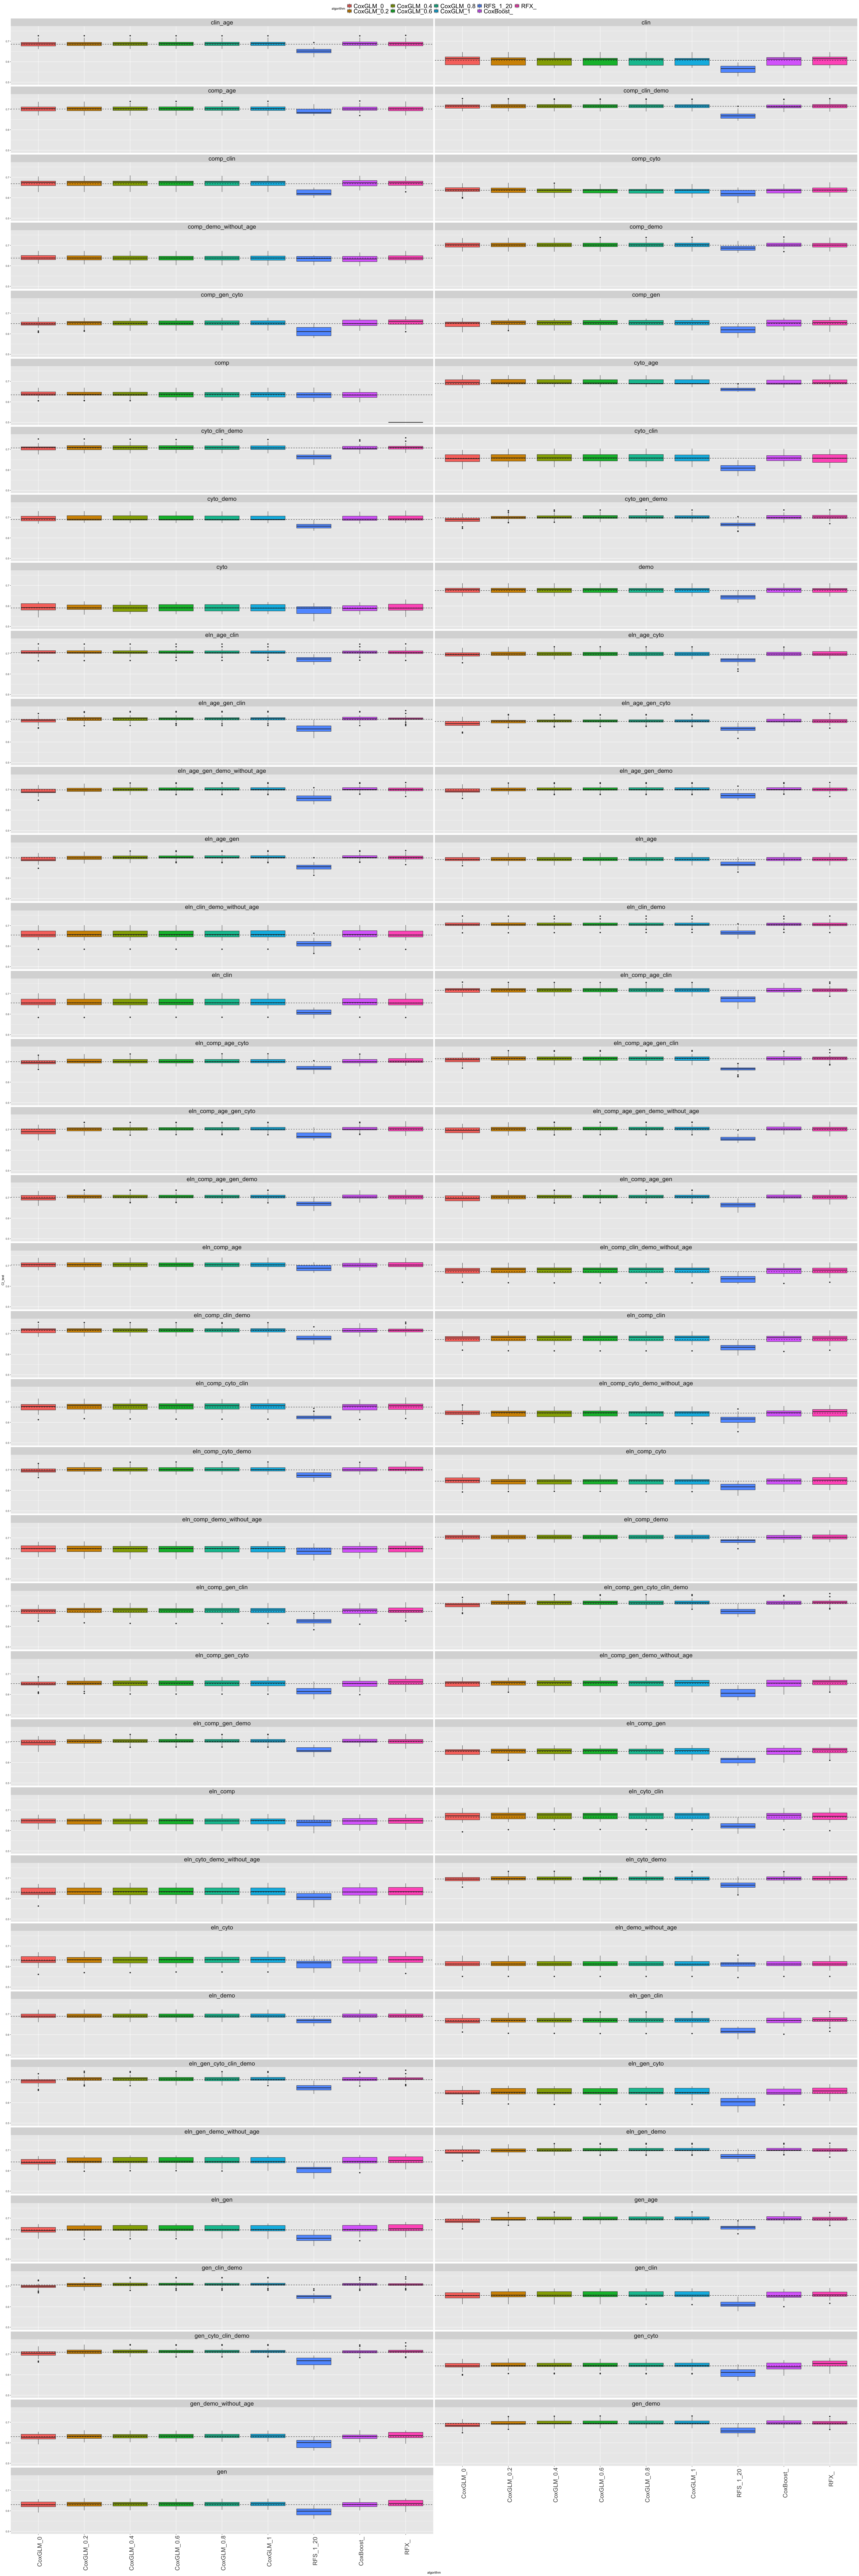

In [11]:
set_notebook_plot_size(40,120)
ggplot(df_w_all,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",strip.text = element_text(size=20),axis.text.x = element_text(size=20,angle = 90, hjust = 0.8,vjust=0.8),legend.text=element_text(size=20)) 

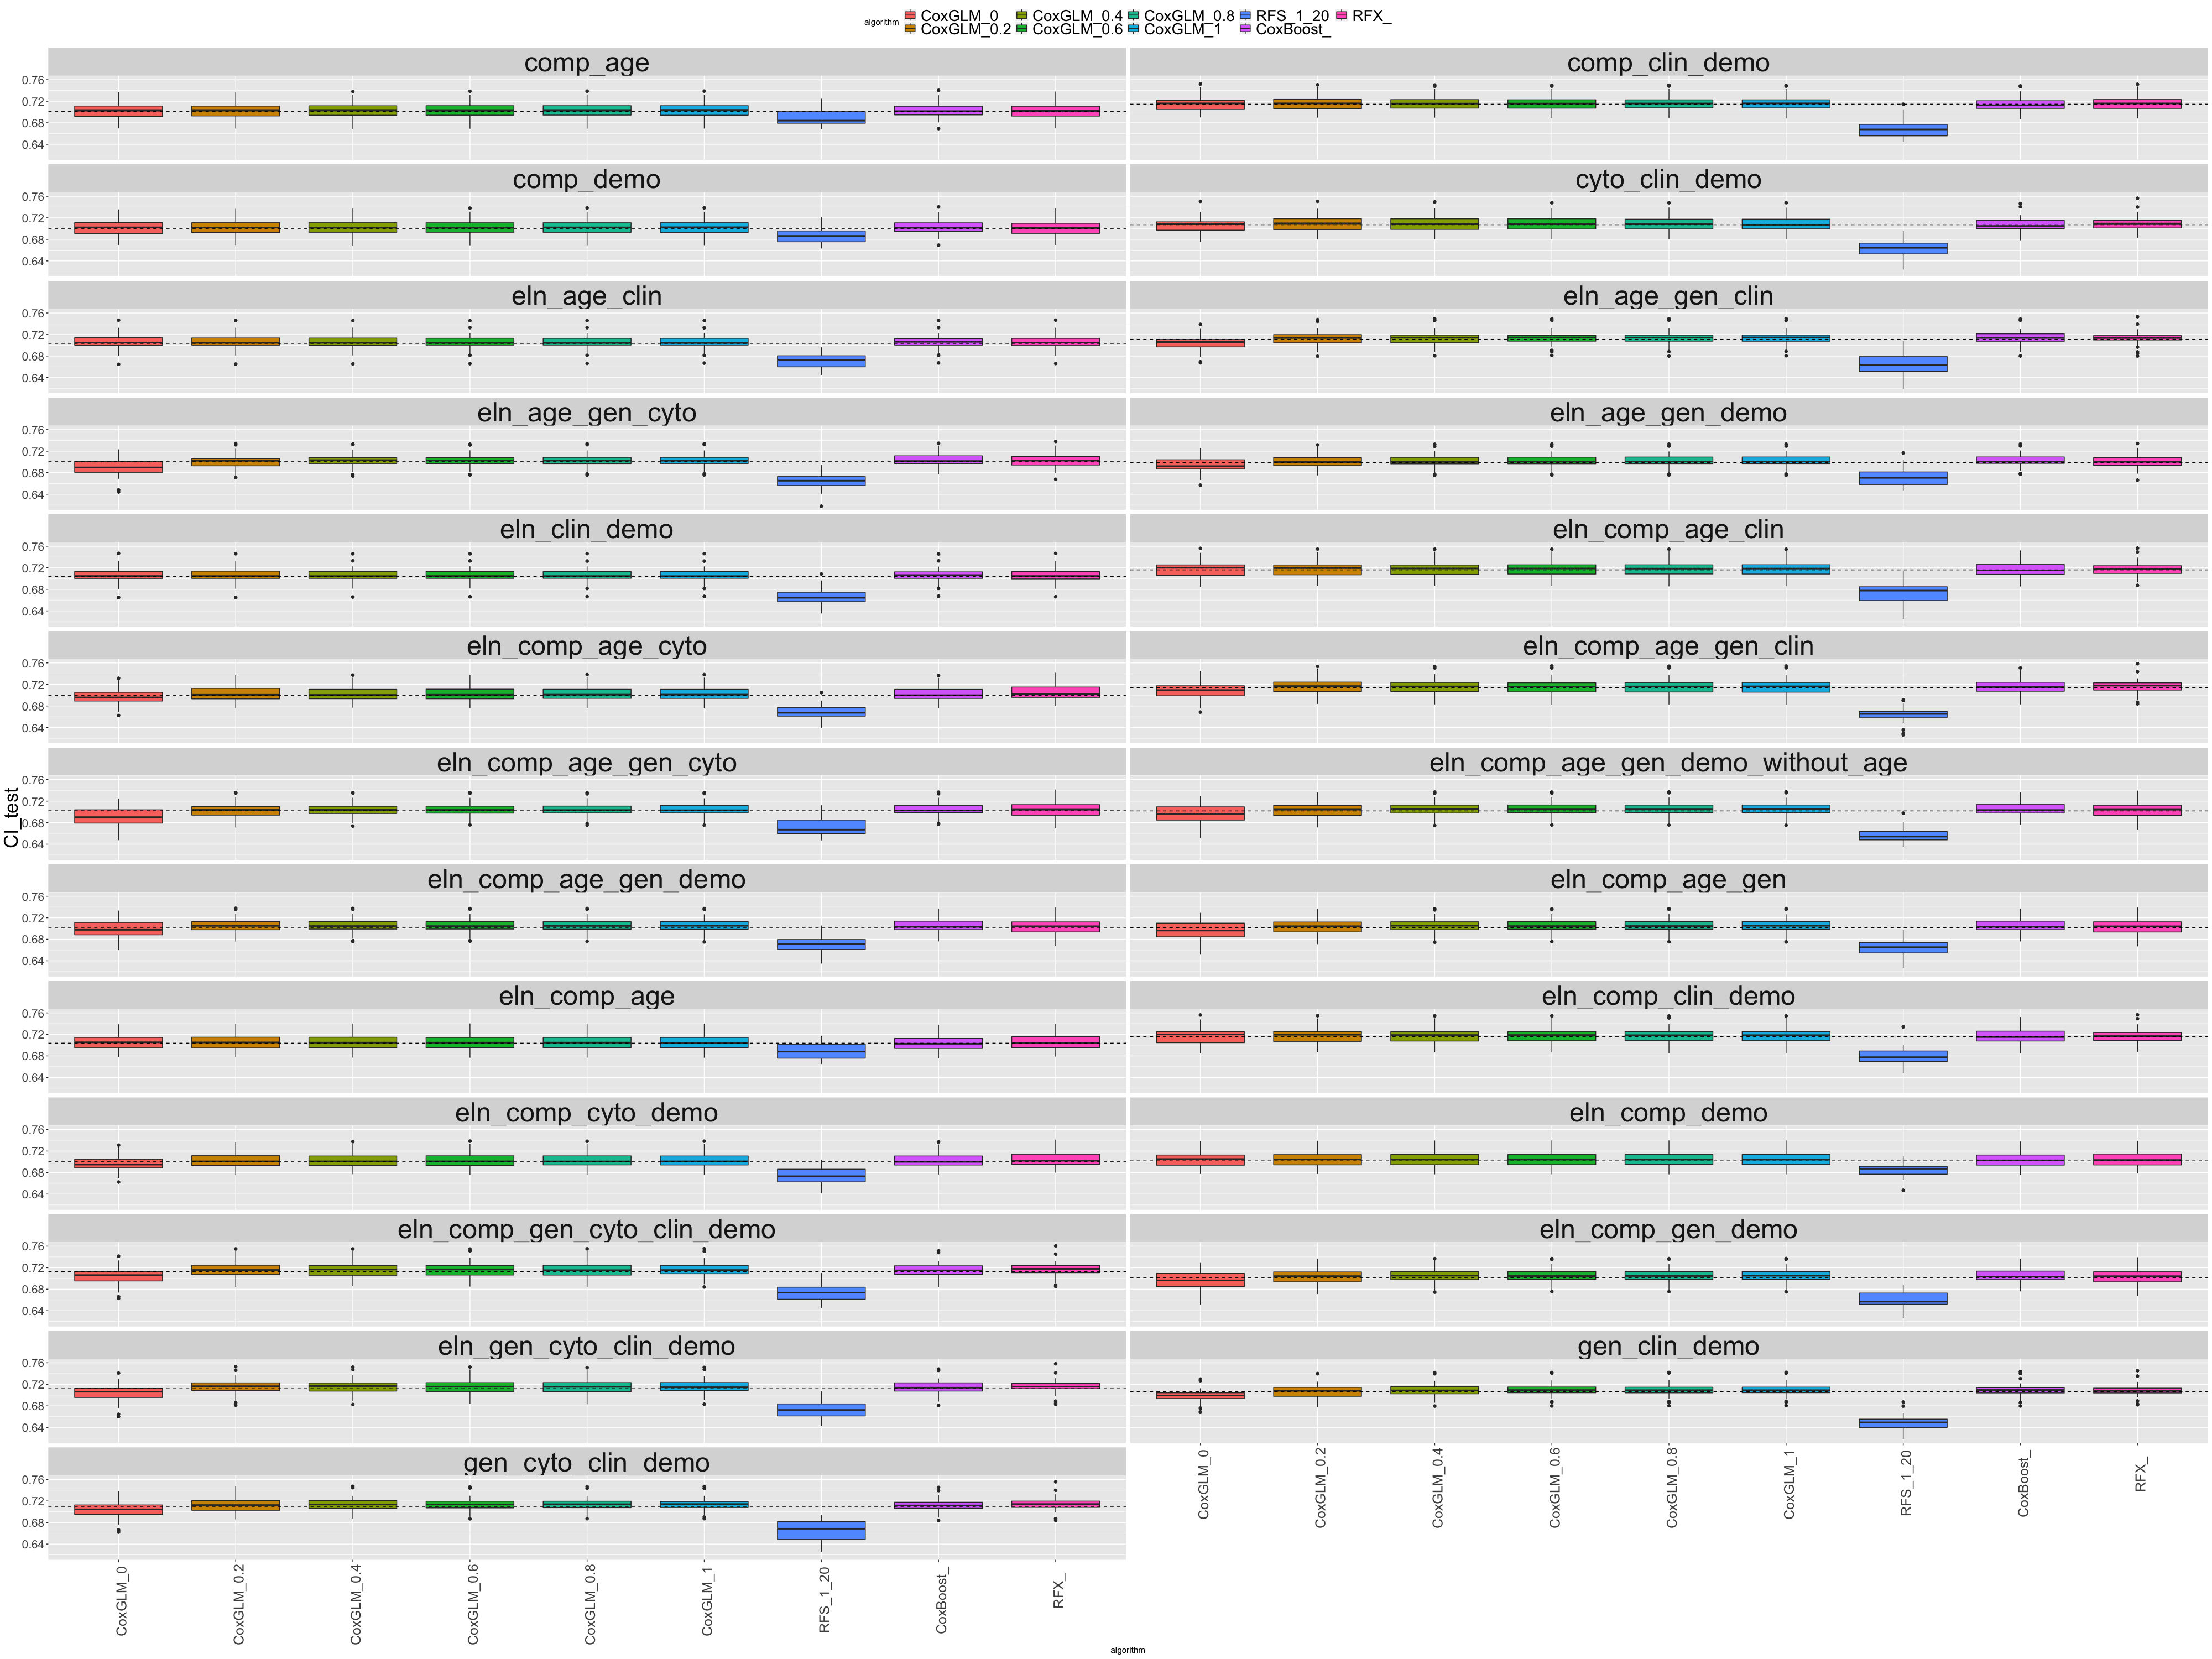

In [12]:
set_notebook_plot_size(40,30)
ggplot(df_w_top,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = top, aes(yintercept = Z), linetype = 2)+
    theme(strip.text = element_text(size=35),legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y = element_text(size=15),axis.title.y=element_text(size=25),legend.text=element_text(size=20)) 